In [91]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import re 

# needed for access to Llama tokenizer
from huggingface_hub import login
login(token="INSERT TOKEN")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/sr100@hsg.privat/.cache/huggingface/token
Login successful
Using cuda


In [2]:
# Load usmle MedQA dataset
train_dataset = load_dataset("GBaker/MedQA-USMLE-4-options", split="train")

print(f"Dataset has {len(train_dataset)} questions") # has 'question', 'answer' as x, and 'options{'A': x, 'B': y, 'C': z, 'D': v} and 'answer_idx' is 'A'
print(train_dataset[0])
print(train_dataset[1])
print(train_dataset[2])

Dataset has 10178 questions
{'question': 'A 23-year-old pregnant woman at 22 weeks gestation presents with burning upon urination. She states it started 1 day ago and has been worsening despite drinking more water and taking cranberry extract. She otherwise feels well and is followed by a doctor for her pregnancy. Her temperature is 97.7°F (36.5°C), blood pressure is 122/77 mmHg, pulse is 80/min, respirations are 19/min, and oxygen saturation is 98% on room air. Physical exam is notable for an absence of costovertebral angle tenderness and a gravid uterus. Which of the following is the best treatment for this patient?', 'answer': 'Nitrofurantoin', 'options': {'A': 'Ampicillin', 'B': 'Ceftriaxone', 'C': 'Doxycycline', 'D': 'Nitrofurantoin'}, 'meta_info': 'step2&3', 'answer_idx': 'D', 'metamap_phrases': ['23 year old pregnant woman', 'weeks presents', 'burning', 'urination', 'states', 'started 1 day', 'worsening', 'drinking', 'water', 'taking cranberry extract', 'feels well', 'followed b

In [3]:
# chunk long texts to 300 words to roughly match context length of embedding model
def chunk_text(text, max_length=300):
    words = text.split()
    chunks = []
    current_chunk = []
    current_length = 0

    for word in words:
        if current_length + len(word) + 1 > max_length:
            chunks.append(" ".join(current_chunk))
            current_chunk = [word]
            current_length = len(word)
        else:
            current_chunk.append(word)
            current_length += len(word) + 1

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks

def encode_questions(dataset, model, device):
    encoded_questions = []
    
    for item in dataset:
        question = item['question']
        chunks = chunk_text(question)
        chunk_embeddings = []
        
        for chunk in chunks:
            embedding = model.encode(chunk, convert_to_tensor=True).to(device)
            chunk_embeddings.append(embedding)
        
        if len(chunk_embeddings) > 1:
            question_embedding = torch.mean(torch.stack(chunk_embeddings), dim=0)
        else:
            question_embedding = chunk_embeddings[0]
        
        encoded_questions.append(question_embedding.cpu().numpy())
    
    return encoded_questions

# Load the embedding model
embedding_model = SentenceTransformer('thenlper/gte-large')
embedding_model.to(device)

# Encode train and test questions
train_encodings = encode_questions(train_dataset, embedding_model, device)

print(f"Encoded {len(train_encodings)} questions")
print(f"Encoding dimension: {train_encodings[0].shape}")

np.save('train_encodings.npy', np.array(train_encodings))

Encoded 10178 questions
Encoding dimension: (1024,)


In [3]:
question_embeddings = np.load('train_encodings.npy')
question_similarities = cosine_similarity(question_embeddings, question_embeddings)

In [80]:
def load_model(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)
    return tokenizer, model

# Define model
#model_name = "microsoft/Phi-3-mini-128k-instruct"
#model_name = "TinyLlama/TinyLlama-1.1B-Chat-v0.1"
model_name = "google/gemma-2-2b-it"
#model_name = "HuggingFaceTB/SmolLM-1.7B-Instruct"

tokenizer, model = load_model(model_name)

# Uncomment to use OpenELM
#tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf", trust_remote_code=True)
#model = AutoModelForCausalLM.from_pretrained("apple/OpenELM-3B", trust_remote_code=True)

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


In [50]:
def dynamic_few_shot_prompt(question, choices, question_index, k=5):
    prompt = ''
    nearest_indices = []
    if k > 0:
        similarities = question_similarities[question_index]
        similarities[question_index] = -1
        nearest_indices = np.argsort(similarities)[-k:][::-1]

    #prompt = "You are a medical assistant and have to answer medical questions.\n\n"
    prompt=''

    for idx in nearest_indices:
        example = train_dataset[int(idx)]
        prompt += f"""\n {example['question']} \n 
              A. {example['options']['A']}
              B. {example['options']['B']}
              C. {example['options']['C']}
              D. {example['options']['D']} \n 
              Think step by step, explain your answer and then provide the correct answer letter. Make sure to first provide the correct answer letter: {example['answer_idx']}\n Explanation: ... \n
        """
    prompt += f"""
             \n {question} \n\n
              A. {choices[0]} \n
              B. {choices[1]} \n
              C. {choices[2]} \n
              D. {choices[3]} \n 
              Think step by step, explain your answer and then provide the correct answer letter. Make sure to first provide the correct answer letter:
    """
    return prompt

def create_simple_prompt(question, choices):
    prompt = f"""
              \n {question} \n 
              A. {choices[0]}
              B. {choices[1]}
              C. {choices[2]}
              D. {choices[3]} \n 
              Answer only with the correct letter. The correct answer letter is:
    """
    return prompt

# Answer a question
def answer_multiple_choice(model, tokenizer, question, choices, question_index):
    if PROMPTING_STRAT == 'simple':
        prompt = create_simple_prompt(question, choices)
    if PROMPTING_STRAT == 'dfs':
        prompt = dynamic_few_shot_prompt(question, choices, question_index, k=K)

    predicted_answers = []
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    for n in range(N_ENSEMBLE):
        with torch.no_grad():
            output_ids = model.generate(
                inputs['input_ids'],
                max_new_tokens=500,  
                pad_token_id=0,
                num_return_sequences=1,
                do_sample=True,
                temperature=0.7,
                top_k=50,
                top_p=0.95,
                no_repeat_ngram_size=3,
            )

        generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        answer_part = generated_text.split(prompt[-25:])[-1]

        # Extract the first letter from the answer part
        #predicted_answer = answer_part[0] if answer_part else ""
        matches = re.findall(r'\b([ABCD])\.?\b', answer_part, re.IGNORECASE)

        if matches:
            predicted_answer_letter = matches[0].upper()
        else: 
            predicted_answer_letter = 'X'
        if predicted_answer_letter not in ['A', 'B', 'C', 'D']:
            # If it's not a valid letter, default to 'X'
            predicted_answer_letter = 'X' # wrong answer
        
        predicted_answers.append(predicted_answer_letter)

    return predicted_answers

In [51]:
def evaluate_model(model, tokenizer, dataset):
    correct = 0
    total = 0
    question_index = 0
    invalid = 0

    model.to(device)

    progress_bar = tqdm(dataset, desc="Evaluating")
    for example in progress_bar:
        question = example['question']
        choices = [example['options']['A'], example['options']['B'], example['options']['C'], example['options']['D']]
        
        # both uppercase
        correct_answer_letter = example['answer_idx'].upper()  # 'A/B/C/D'
        predicted_answer_letters = answer_multiple_choice(model, tokenizer, question, choices, question_index)
        predicted_answer_letter = max(set(predicted_answer_letters), key=predicted_answer_letters.count)

        if predicted_answer_letter == correct_answer_letter:
            correct += 1
        if predicted_answer_letter == 'X':
            invalid += 1
        total += 1
        question_index += 1
        progress_bar.set_postfix({"Correct": f"{correct}/{total}", "Invalid": f"{invalid}/{total}", "Current Answer": predicted_answer_letter})

    accuracy = correct / total
    return accuracy

In [81]:
PROMPTING_STRAT = 'dfs'  # simple or k dynamic few shot (dfs) 
K = 0 # if using dfs how many examples for in-context-learning 
N_ENSEMBLE = 1 # how many text generations to run, most frequent answer is used
accuracy = evaluate_model(model, tokenizer, train_dataset.select(range(100)))
print(f"Accuracy: {accuracy:.2%}")

Evaluating: 100%|██████████| 100/100 [19:52<00:00, 11.93s/it, Correct=48/100, Invalid=0/100, Current Answer=C]

Accuracy: 48.00%


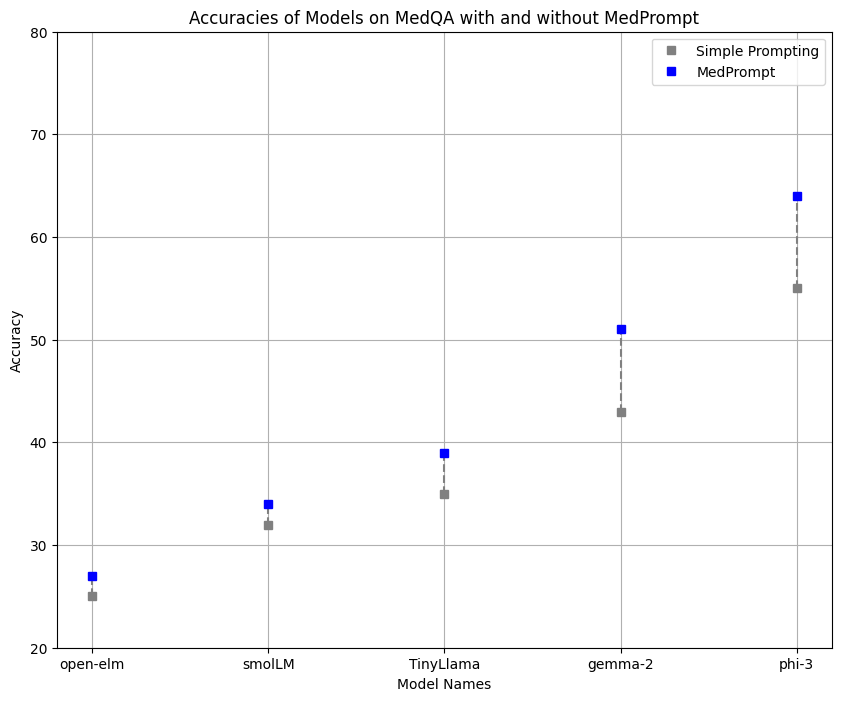

In [89]:
# Visualize results
import matplotlib.pyplot as plt

model_names = ['open-elm', 'smolLM', 'TinyLlama', 'gemma-2', 'phi-3']
accuracies = [25, 32, 35, 43, 55]
accuracies_medprompt = [27, 34, 39, 51, 64]

plt.figure(figsize=(10, 8))

for i in range(len(model_names)):
    plt.plot(model_names[i], accuracies[i], 's', color='grey', label=f'Simple Prompting' if i == 0 else "")
    plt.plot([model_names[i], model_names[i]], [accuracies[i], accuracies_medprompt[i]], linestyle='--', color='gray')
    plt.plot(model_names[i], accuracies_medprompt[i], 'bs', label=f'MedPrompt' if i == 0 else "")

# Customizing the plot
plt.xlabel('Model Names')
plt.ylabel('Accuracy')
plt.title('Accuracies of Models on MedQA with and without MedPrompt')
plt.legend()
plt.grid(True)
plt.ylim(20, 80)
plt.savefig('result.png')
# Show plot
plt.show()
